# Exploratory Data Analysis (EDA)

This notebook performs exploratory data analysis on stock price data to understand its statistical properties, identify patterns, and prepare for LSTM model training.

## Objective:

- Validate statistical properties of price and returns
- Inspect volatility & trend regimes
- Detect potential data leakage
- Support LSTM + walk-forward trading design

In [ ]:
# Import required libraries for data analysis and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style for consistent and clean plots
plt.style.use("seaborn-v0_8")
sns.set_context("notebook")

# Configure pandas to display floating point numbers with 6 decimal places
pd.set_option("display.float_format", "{:.6f}".format)

# Import data loading utility from the project
from src.data.loader import load_data

## Data Loading

Load historical stock data for AAPL (Apple Inc.) from January 1, 2022 onwards.

In [2]:
# Define stock ticker and date range for analysis
ticker = "AAPL"
start_date = "2022-01-01"
end_date = None  # None means use the latest available date

# Load the stock data using the custom data loader
df = load_data(ticker, start_date, end_date)

# Display first few rows to verify data was loaded correctly
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2022-01-03,178.103668,178.955006,173.895967,174.013387,104487900
2022-01-04,175.843216,179.013683,175.275662,178.710339,99310400
2022-01-05,171.165848,176.303172,170.891858,175.755193,94537600
2022-01-06,168.308487,171.537664,167.956213,168.993460,96904000
2022-01-07,168.474854,170.402574,167.359321,169.179402,86709100


## Data Inspection

Examine the structure, data types, and basic statistics of the loaded dataset.

In [3]:
# Display data types, column info, and memory usage
# This helps identify any missing values or incorrect data types
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1036 entries, 2022-01-03 to 2026-02-19
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1036 non-null   float64
 1   (High, AAPL)    1036 non-null   float64
 2   (Low, AAPL)     1036 non-null   float64
 3   (Open, AAPL)    1036 non-null   float64
 4   (Volume, AAPL)  1036 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 48.6 KB


In [4]:
# Display statistical summary of all numeric columns
# Includes count, mean, std, min, max, and quartiles
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000
mean,192.168797,194.089290,190.091906,192.000390,64256983.397683
std,39.039320,39.250116,38.825500,39.054226,27608998.746357
min,123.046791,125.753387,122.210219,124.021194,17910600.000000
25%,162.688530,164.067528,161.342205,162.616641,45809325.000000
50%,185.453957,186.758628,183.020254,185.041766,56022900.000000
75%,223.406727,225.366930,221.539906,223.363049,76144000.000000
max,285.922455,288.350192,283.035157,285.932471,318679900.000000


## Data Quality Validation

Perform assertions to ensure data meets quality requirements for analysis.

In [5]:
# Validate data quality with assertions:

# 1. Check that index is DatetimeIndex for time series analysis
assert isinstance(df.index, pd.DatetimeIndex)

# 2. Ensure dates are in chronological order (no future dates mixed in)
assert df.index.is_monotonic_increasing

# 3. Verify there are no missing values in the dataset
assert df.isnull().sum().sum() == 0

## Closing Price Visualization

Plot the historical closing prices to visualize the overall price movement.

<Figure size 1200x400 with 0 Axes>

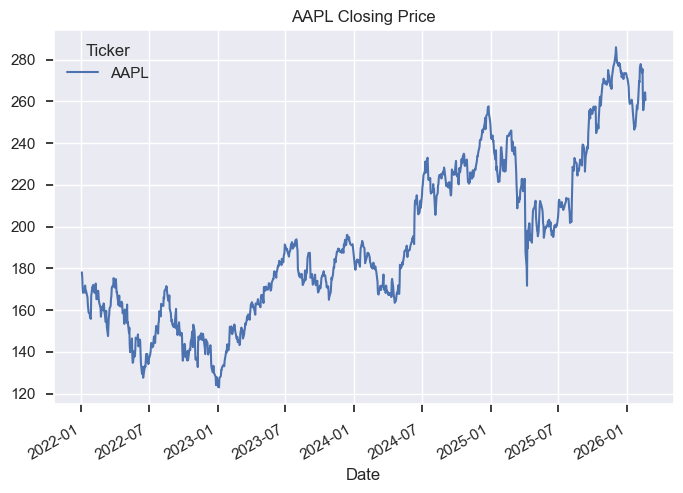

In [6]:
# Create a figure with specified size for better visibility
plt.figure(figsize=(12,4))

# Plot the Close price column over time
df["Close"].plot(title=f"{ticker} Closing Price")

# Display the plot
plt.show()

## Log Returns Calculation

Calculate logarithmic returns, which are preferred over simple returns for statistical analysis due to their time-additivity and better statistical properties.

In [7]:
# Calculate log returns: log(P_t / P_{t-1})
# Log returns are preferred because:
# - They are time-additive (can sum across periods)
# - They have better statistical properties (more normal-like)
# - They are symmetric (gains and losses are treated equally)
df["log_ret"] = np.log(df["Close"]).diff()

# Remove the first row (NaN from diff operation)
df.dropna(inplace=True)

## Log Returns Statistics

Examine the statistical distribution of log returns, including extreme percentiles.

In [8]:
# Display detailed statistics of log returns including extreme percentiles
# This helps identify the range of typical vs extreme returns
df["log_ret"].describe(percentiles=[0.01, 0.05, 0.95, 0.99])

count   1035.000000
mean       0.000368
std        0.017881
min       -0.097013
1%        -0.049313
5%        -0.029295
50%        0.000787
95%        0.026011
99%        0.043552
max        0.142617
Name: log_ret, dtype: float64

## Log Returns Distribution

Visualize the distribution of log returns to check for normality and identify outliers.

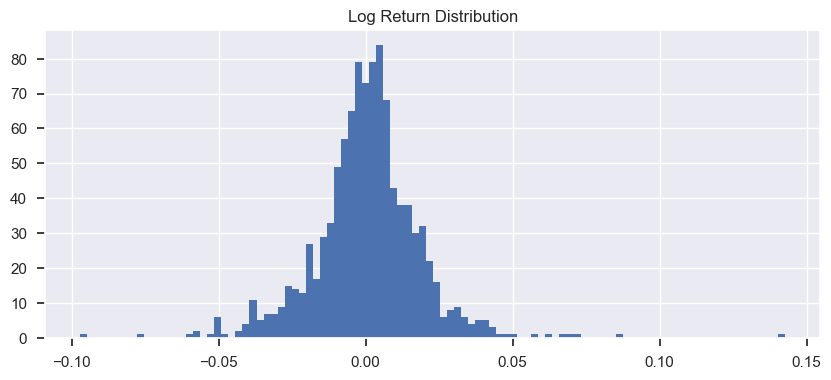

In [9]:
# Create histogram to visualize the distribution of log returns
# 100 bins provide fine granularity to see the shape
plt.figure(figsize=(10,4))
df["log_ret"].hist(bins=100)
plt.title("Log Return Distribution")
plt.show()

## Autocorrelation Analysis

Plot the autocorrelation function (ACF) to check for temporal dependencies in returns.

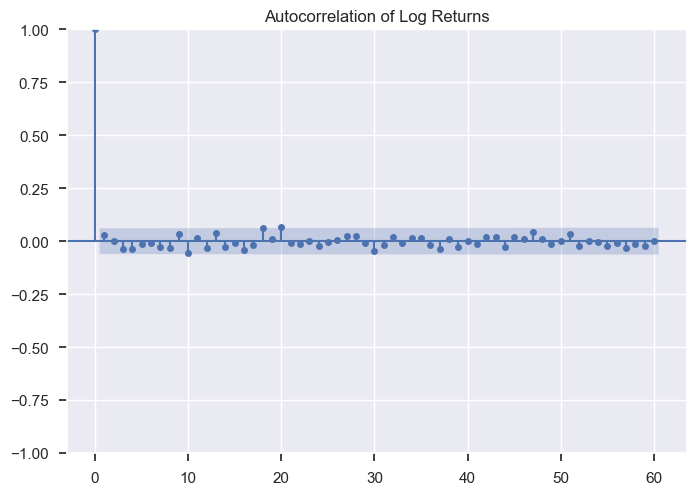

In [11]:
# Import the ACF plotting function from statsmodels
from statsmodels.graphics.tsaplots import plot_acf

# Plot autocorrelation function for lag 1 to 30
# This helps identify if past returns predict future returns
plot_acf(df["log_ret"], lags=60)
plt.title("Autocorrelation of Log Returns")
plt.show()

## Volatility Calculation

Calculate rolling volatility measures to identify volatility regimes and clustering.

In [12]:
# Calculate 20-day rolling standard deviation of returns (short-term volatility)
df["vol_20"] = df["log_ret"].rolling(20).std()

# Calculate 60-day median of the 20-day rolling volatility (long-term volatility baseline)
# Using median is more robust to outliers than mean
df["vol_60_med"] = df["vol_20"].rolling(60).median()

## Volatility Regimes Visualization

Plot the short-term and long-term volatility to identify different market regimes.

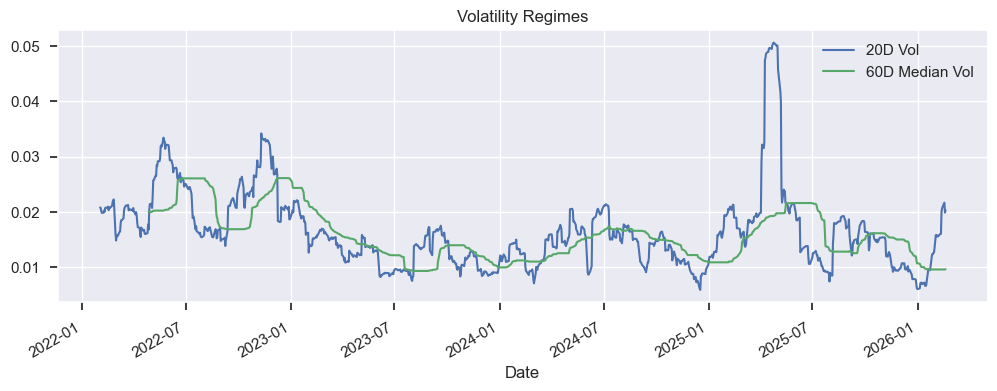

In [13]:
# Plot both volatility measures over time to visualize regimes
plt.figure(figsize=(12,4))
df["vol_20"].plot(label="20D Vol")  # Short-term volatility
df["vol_60_med"].plot(label="60D Median Vol")  # Long-term median volatility
plt.legend()
plt.title("Volatility Regimes")
plt.show()

## Volatility Ratio Analysis

Calculate the ratio of short-term to long-term volatility to identify regime changes.

<Axes: title={'center': 'Volatility Ratio (20D Vol / 60D Median Vol)'}, xlabel='Date'>

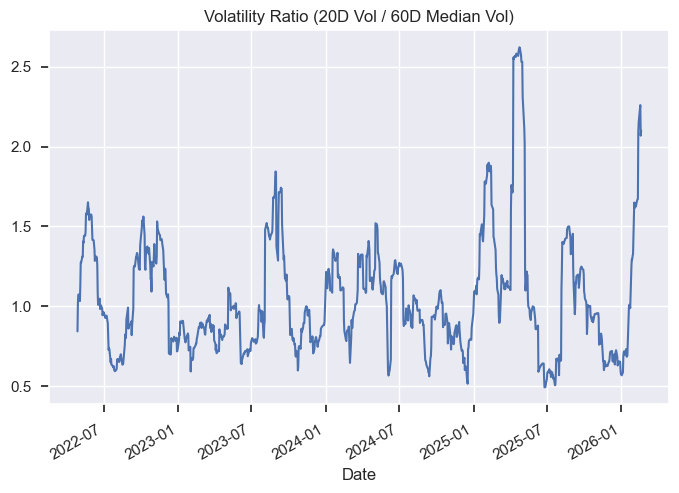

In [16]:
# Calculate volatility ratio: short-term / long-term
# Ratio > 1 indicates increased volatility (high volatility regime)
# Ratio < 1 indicates decreased volatility (low volatility regime)
vol_ratio = df["vol_20"] / df["vol_60_med"]
vol_ratio.plot(title="Volatility Ratio (20D Vol / 60D Median Vol)")

## Volatility Ratio Distribution

Visualize the distribution of volatility ratios to set thresholds for regime classification.

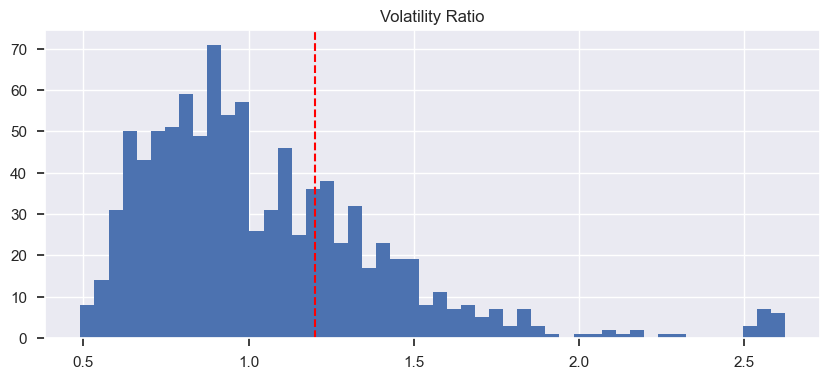

In [17]:
# Plot histogram of volatility ratio to see distribution
plt.figure(figsize=(10,4))
vol_ratio.hist(bins=50)

# Add vertical line at 1.2 to mark potential high-volatility threshold
plt.axvline(1.2, color="red", linestyle="--")
plt.title("Volatility Ratio")
plt.show()

## Trend Strength Calculation

Calculate a measure of trend strength based on price deviation from moving average.

In [19]:
# Calculate 50-day simple moving average of closing prices
close = df["Close"].iloc[:, 0]
df["ma50"] = close.rolling(50).mean()

# Calculate trend strength as absolute percentage deviation from MA
# Higher values indicate stronger trending behavior
df["trend_strength"] = (close - df["ma50"]).abs() / df["ma50"]

## Trend Strength Time Series

Visualize how trend strength evolves over time.

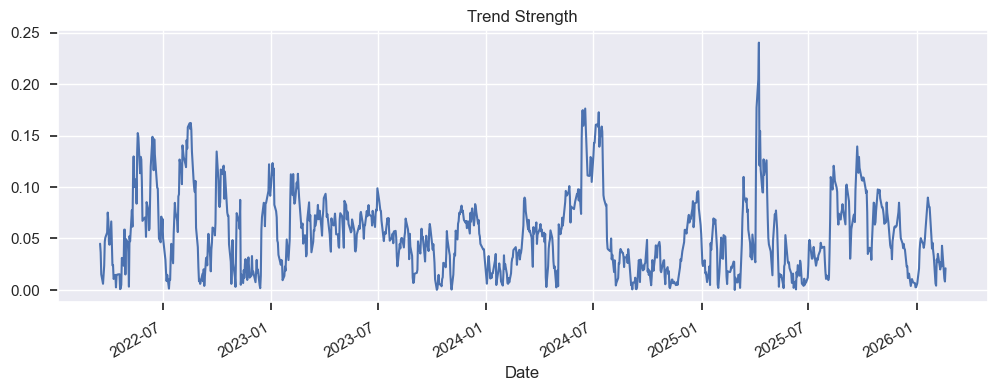

In [20]:
# Plot trend strength over time to see when strong trends occur
plt.figure(figsize=(12,4))
df["trend_strength"].plot(title="Trend Strength")
plt.show()

## Trend Strength Distribution

Visualize the distribution of trend strength to determine threshold for trend identification.

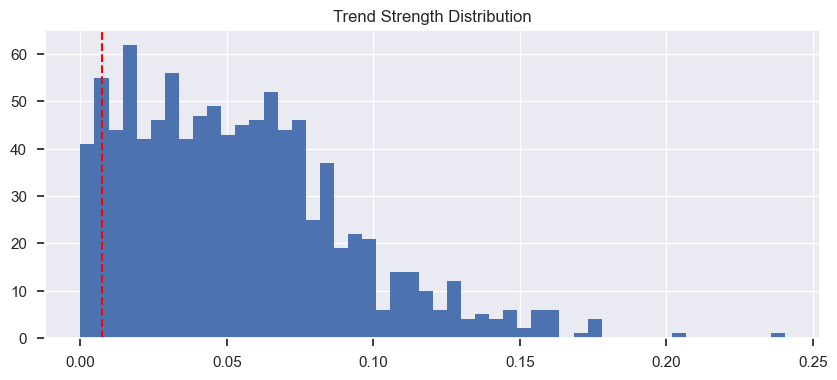

In [21]:
# Plot histogram of trend strength to identify typical vs extreme values
plt.figure(figsize=(10,4))
df["trend_strength"].hist(bins=50)

# Add vertical line at 0.0075 as potential threshold for strong trends
plt.axvline(0.0075, color="red", linestyle="--")
plt.title("Trend Strength Distribution")
plt.show()

## Regime Filtering Definition

Define a regime filter based on volatility and trend strength to identify favorable trading conditions.

In [22]:
# Define regime_ok based on two conditions:
# 1. Short-term volatility is less than 1.2x long-term median (not in high volatility regime)
# 2. Trend strength is greater than 0.75% (strong enough trend to trade)
df["regime_ok"] = (
    (df["vol_20"] < 1.2 * df["vol_60_med"]) &
    (df["trend_strength"] > 0.0075)
)

## Regime Distribution

Examine the proportion of time spent in each regime.

In [23]:
# Show the distribution of regime_ok values as percentages
# This tells us what fraction of time is suitable for trading
df["regime_ok"].value_counts(normalize=True)

regime_ok
True    0.611594
False   0.388406
Name: proportion, dtype: float64

## Feature Correlation Analysis

Examine correlations between different features to understand their relationships.

In [24]:
# Select features for correlation analysis
features = ["log_ret", "vol_20", "trend_strength"]

# Display correlation matrix between selected features
# This helps identify multicollinearity and feature relationships
df[features].corr()

,Price,log_ret,vol_20,trend_strength
,Ticker,,,
Price,Ticker,,,
log_ret,,1.000000,0.004423,-0.027856
vol_20,,0.004423,1.000000,0.213196
trend_strength,,-0.027856,0.213196,1.000000


## Feature Correlation with Future Returns

Calculate how well each feature correlates with next-day returns to assess predictive potential.

In [25]:
# Create target variable: next day's return (what we want to predict)
df["future_ret"] = df["log_ret"].shift(-1)

# Calculate correlation between features and future returns
# This helps assess the predictive power of each feature
df[features].corrwith(df["future_ret"])

Price           Ticker
log_ret                   0.030237
vol_20                   -0.012747
trend_strength            0.078635
dtype: float64

## Key Takeaways

Summary of findings from the exploratory data analysis:

- Returns are noisy with near-zero autocorrelation
- Volatility clustering is present
- Trend regimes exist but are intermittent
- Regime filtering is justified
- Forecasting alone is weak → filtering & sizing are critical